# Amazon Alexa Sentiment Analysis

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from spacy import displacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score
#import en_core_web_sm

plt.style.use('fivethirtyeight')


In [2]:
#reading file
df=pd.read_csv("amazon_alexa.tsv",sep="\t",encoding="ISO-8859-1")
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


### Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
rating              3150 non-null int64
date                3150 non-null object
variation           3150 non-null object
verified_reviews    3150 non-null object
feedback            3150 non-null int64
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [4]:
df.shape


(3150, 5)

In [5]:
df.describe()


,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [6]:
df.isna().mean(axis=0)

rating              0.0
date                0.0
variation           0.0
verified_reviews    0.0
feedback            0.0
dtype: float64

In [7]:
df['feedback'].value_counts()

1    2893
0     257
Name: feedback, dtype: int64

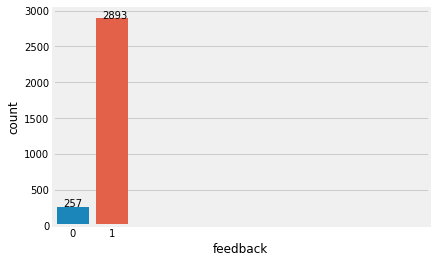

In [8]:
#plt.figure(figsize=(15,5))
ax=sns.countplot(data=df,x='feedback');
#for p, label in zip(ax.patches, df["feedback"].value_counts().index):
 #   ax.annotate(label, (p.get_x()+0.375, p.get_height()+0.15))
ax.set_xticks(np.arange(10))
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

In [9]:
df['feedback'].mean()

0.9184126984126985

91% of the data has positive reviews

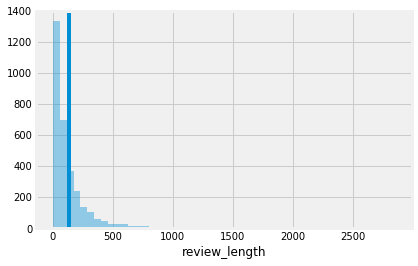

In [10]:
#seeing the distribution of word length
df['review_length']=df['verified_reviews'].apply(len)

#fig = plt.figure(1, figsize=(10,6))
sns.distplot(df['review_length'],kde=False);
plt.axvline(x=df['review_length'].mean(), ymin=0,ymax=1);

In [11]:
df['review_length'].mean()

132.50063492063492

Avergae review length is around 132 words.

In [12]:
df['date']=pd.to_datetime(df['date'], format="%d-%b-%y")
df.dtypes

rating                       int64
date                datetime64[ns]
variation                   object
verified_reviews            object
feedback                     int64
review_length                int64
dtype: object

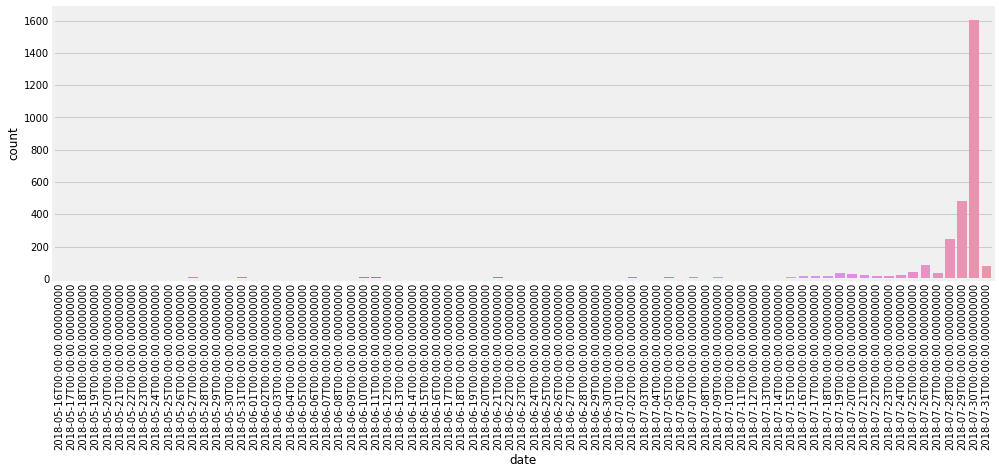

In [13]:
plt.figure(figsize=(15,5))
ax=sns.countplot(df['date'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


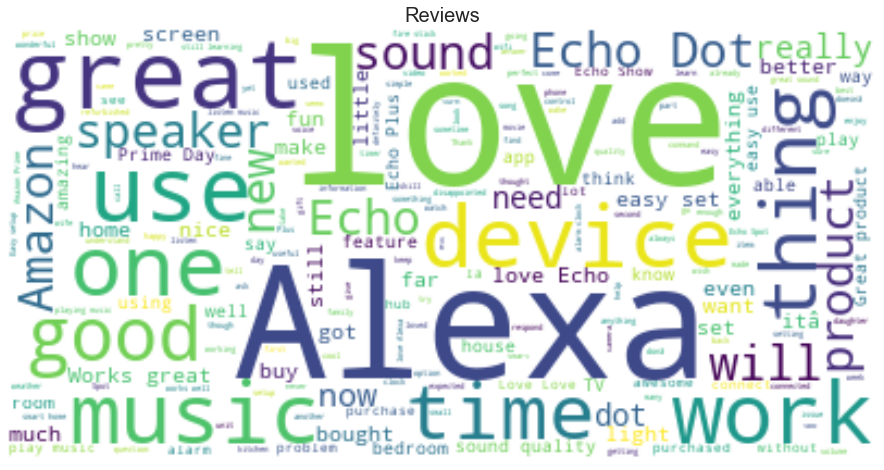

In [14]:
np.random.seed(10)
sns.set(rc={'figure.figsize':(14,8)})
reviews = ' '.join(df['verified_reviews'].tolist())

wordcloud = WordCloud(background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.show()

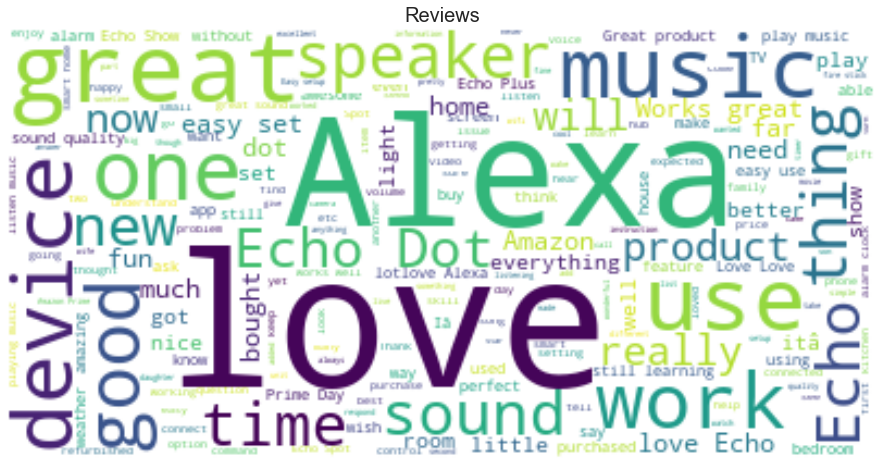

In [15]:
df_positive=df[df['feedback']==1]
sns.set(rc={'figure.figsize':(14,8)})
reviews = ' '.join(df_positive['verified_reviews'].tolist())

wordcloud = WordCloud(background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.show()

Mostly contains words such as alexa, love,music,one,speaker,good,device,great

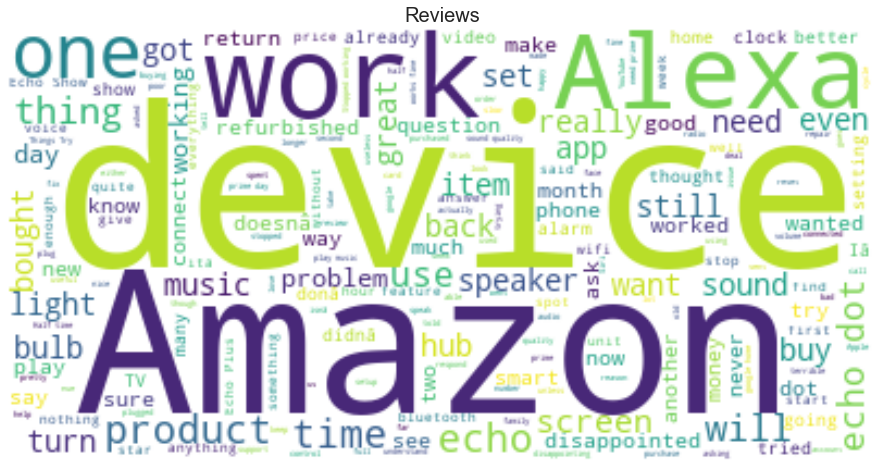

In [16]:
df_negative=df[df['feedback']==0]
sns.set(rc={'figure.figsize':(14,8)})
reviews = ' '.join(df_negative['verified_reviews'].tolist())

wordcloud = WordCloud(background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.show()

Contains words like never,disappointed,tried,problem,still.

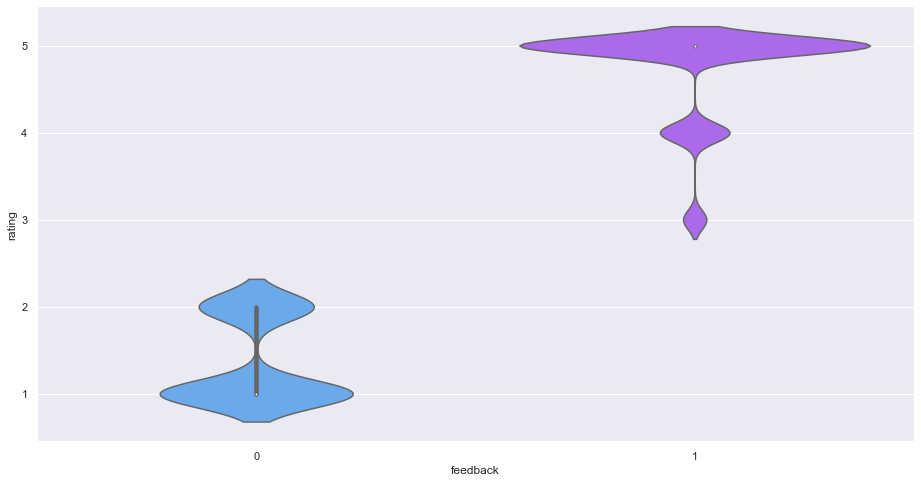

In [17]:

sns.violinplot(df['feedback'], df['rating'], palette = 'cool')

### Tokenizing data with NLTK

Let's create a custom function using NLTK which will automatically strip words that we dont need. Few of these words include stopwords, punctuations, special characters.

### Using BOW
#### Tokenization

In [43]:
from string import punctuation

punctuations = string.punctuation
df['verified_reviews'] = df.verified_reviews.apply(lambda x: x.lower())
df['verified_reviews'] = df.verified_reviews.apply(lambda x: ''.join([c for c in x if c not in punctuation]))
from nltk.tokenize import word_tokenize
word_tokenize(df.verified_reviews[0])

['love', 'my', 'echo']

In [44]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

sw = set(stopwords.words('english'))

df['token_reviews'] = df.verified_reviews.apply(lambda x: word_tokenize(x))
df['clean_reviews'] = df.token_reviews.apply(lambda x : [word for word in x if word not in sw] )
df['clean_reviews'] = df.clean_reviews.apply(lambda x : " ".join(x))
df.head()


,rating,date,variation,verified_reviews,feedback,review_length,token_reviews,clean_reviews
0,5,2018-07-31,Charcoal Fabric,love my echo,1,13,"[love, my, echo]",love echo
1,5,2018-07-31,Charcoal Fabric,loved it,1,9,"[loved, it]",loved
2,4,2018-07-31,Walnut Finish,sometimes while playing a game you can answer ...,1,195,"[sometimes, while, playing, a, game, you, can,...",sometimes playing game answer question correct...
3,5,2018-07-31,Charcoal Fabric,i have had a lot of fun with this thing my 4 y...,1,172,"[i, have, had, a, lot, of, fun, with, this, th...",lot fun thing 4 yr old learns dinosaurs contro...
4,5,2018-07-31,Charcoal Fabric,music,1,5,[music],music


## Classification

### 1. Random Forest classification

In [21]:
y=df['feedback']
X_train, X_test, y_train, y_test = train_test_split(df["clean_reviews"], y, test_size=0.3,random_state=10)

In [39]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfTransformer

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words="english")

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

y_train = np.asarray(y_train.values)

ch2 = SelectKBest(chi2, k = 300)

X_new = ch2.fit_transform(count_train, y_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

X_test_new = ch2.transform(X=count_test)

In [23]:
count_vectorizer = CountVectorizer(stop_words="english")

def TextPreprocessor(train,train_y,test):
        
    CountVectorizer(stop_words="english")
    count = count_vectorizer.fit_transform(train)
    count_test = count_vectorizer.transform(X_test)
    
    tfidf_vectorizer = TfidfTransformer()
    tfidf = tfidf_vectorizer.fit_transform(count)
    tfidf_test = tfidf_vectorizer.transform(count_test)
    
    ch2 = SelectKBest(chi2, k = 300)
    
    X_new = ch2.fit_transform(count_train, y_train)
    
    train_new = ch2.fit_transform(tfidf, y_train)
    test_new = ch2.transform(tfidf_test)
    
    return train_new, test_new

 ### Naive Bayes Classifier

In [24]:
train_set, test_set = TextPreprocessor(X_train, y_train, X_test)

In [51]:
#Building a Naive bayes classifier for classification
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()

#fitting train data in the classifier
classifier.fit(train_set.todense(), y_train)
classifier.score(train_set.todense(), y_train)

0.9809523809523809

In [53]:
#Testing our classifier onto test data and storing the results in y_pred variable
y_pred = classifier.predict(test_set.todense())

In [54]:
#Checking accuracy of predictions on test data
#We are using confusion matrix from sklearn.metrics
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print((cm[0,0]+cm[1,1])/cm.sum()*100)

90.7936507936508


In [25]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

rf_clf = RandomForestClassifier(random_state=10)
# Fit the classifier to the training data
rf_clf.fit(train_set, y_train)

# Create the predicted tags: pred
pred_rf = rf_clf.predict(test_set)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred_rf)
print('Accuracy is:',score)

f1 = metrics.f1_score(y_test, pred_rf)
print('F score is:',f1)

Accuracy is: 0.928042328042328
F score is: 0.9617977528089887


C:\Users\leksh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


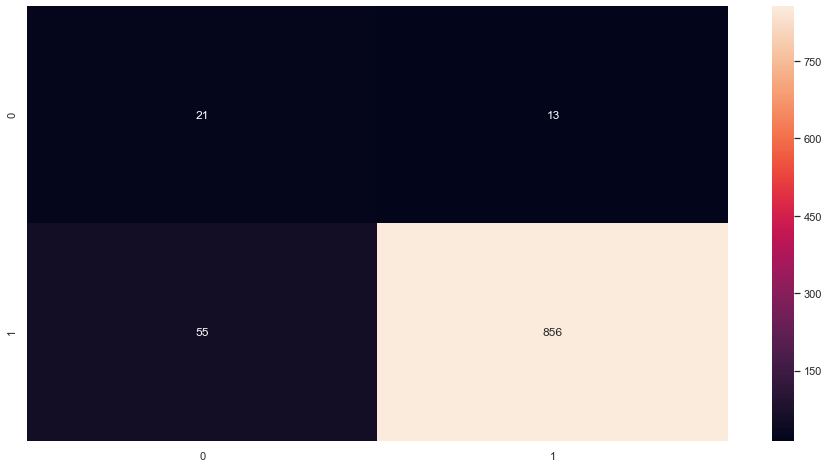

In [26]:
sns.heatmap(metrics.confusion_matrix(pred_rf,y_test),annot=True,fmt='2.0f')

In [27]:
from sklearn.model_selection import GridSearchCV
randfor_clf = RandomForestClassifier()
metrics_score = metrics.make_scorer(metrics.fbeta_score, beta=0.5)
parameters = {'n_estimators': [150, 180, 250], 'max_features': [120,150], 'max_depth': [120,135,150],'min_samples_split':[3,5],'min_samples_leaf':[1,3,5]}

grid_obj = GridSearchCV(randfor_clf, parameters, scoring=metrics_score)

grid_fit = grid_obj.fit(X_new, y_train)


C:\Users\leksh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [28]:
best_randforclf = grid_fit.best_estimator_

best_predictions = best_randforclf.predict(X_test_new)

score = metrics.accuracy_score(y_test, best_predictions)
print('Accuracy is:',score)
f1 = metrics.f1_score(y_test, best_predictions)
print('F score is:',f1)

Accuracy is: 0.9291005291005291
F score is: 0.9622960045019696


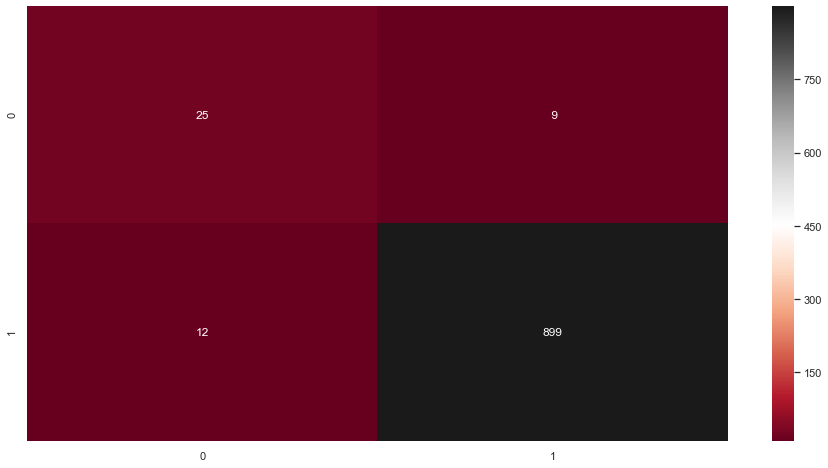

In [29]:
sns.heatmap(metrics.confusion_matrix(pred_rf,best_predictions),annot=True,fmt='2.0f', cmap="RdGy")

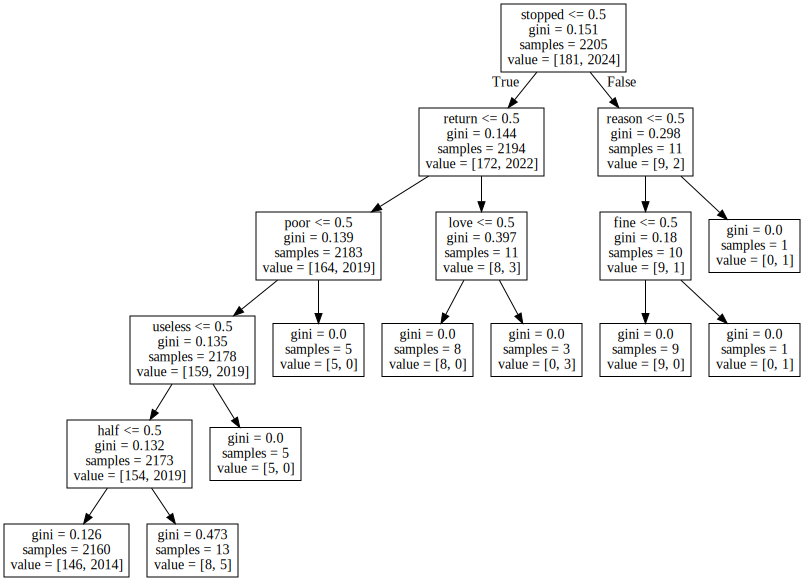

In [30]:
from sklearn.tree import DecisionTreeClassifier

from itertools import compress

features = count_vectorizer.get_feature_names()
mask = ch2.get_support()
features = list(compress(features, mask))
importances = best_randforclf.feature_importances_

tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(X_new, y_train)

from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(tree_model, feature_names=features)
graphviz.Source(tree_graph)

# Startified sampling

In [55]:
# Number of data points in the minority class
number_records_negative = len(df[df['feedback']==0])
negative_indices = np.array(df[df['feedback']==0].index)


# Picking the indices of the normal classes
positive_indices = df[df['feedback']==1].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_positive_indices = np.random.choice(positive_indices, number_records_negative, replace = False)
random_positive_indices = np.array(random_positive_indices)
random_positive_indices.shape

(257,)

In [56]:
# Appending the 2 indices
under_sample_indices = np.concatenate([negative_indices,random_positive_indices])

# Under sample dataset
under_sample_data = df.iloc[under_sample_indices,:]



In [57]:
X_undersample = under_sample_data.ix[:, under_sample_data.columns == 'clean_reviews']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'feedback']

# Showing ratio
print("Percentage of postive sentiments: ", len(under_sample_data[under_sample_data.feedback == 1])/len(under_sample_data))
print("Percentage of negative sentiments: ", len(under_sample_data[under_sample_data.feedback == 0])/len(under_sample_data))
print("Total number of sentiments in resampled data: ", len(under_sample_data))

Percentage of postive sentiments:  0.5
Percentage of negative sentiments:  0.5
Total number of sentiments in resampled data:  514


C:\Users\leksh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\leksh\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
C:\Users\leksh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
htt

In [58]:
X_undersample = X_undersample['clean_reviews'].iloc[:,]
y_undersample = df['feedback'].iloc[:,]

In [59]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_undersample,y_undersample,test_size = 0.25, random_state = 0)

ValueError: Found input variables with inconsistent numbers of samples: [514, 3150]

In [36]:
y_train_new.shape

NameError: name 'y_train_new' is not defined

In [ ]:
# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train_new)

y_train = np.asarray(y_train_new.values)

ch2 = SelectKBest(chi2, k = 300)
X_new = ch2.fit_transform(count_train, y_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test_new)

X_test_new = ch2.transform(X=count_test)


In [ ]:
count_vectorizer = CountVectorizer(stop_words="english")

def TextPreprocessor(train,train_y,test):
        
    CountVectorizer(stop_words="english")
    count = count_vectorizer.fit_transform(train)
    count_test = count_vectorizer.transform(X_test)
    
    tfidf_vectorizer = TfidfTransformer()
    tfidf = tfidf_vectorizer.fit_transform(count)
    tfidf_test = tfidf_vectorizer.transform(count_test)
    
    ch2 = SelectKBest(chi2, k = 300)
    
    X_new = ch2.fit_transform(count_train, y_train)
    
    train_new = ch2.fit_transform(tfidf, y_train)
    test_new = ch2.transform(tfidf_test)
    
    return train_new, test_new

In [ ]:
train_set, test_set = TextPreprocessor(X_train, y_train, X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

rf_clf = RandomForestClassifier(random_state=10)
# Fit the classifier to the training data
rf_clf.fit(train_set, y_train)

# Create the predicted tags: pred
pred_rf = rf_clf.predict(test_set)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred_rf)
print('Accuracy is:',score)

f1 = metrics.f1_score(y_test, pred_rf)
print('F score is:',f1)